[<img src="https://github.com/ryayoung/icons/blob/main/svg/arrow.left.blue.svg" height="30"/>](https://github.com/ryayoung/transshipment-optimization)

# **Ski Boot Manufacturing**
## *Multi-stage Transshipment*

> Original problem created by [Ryan Elmore](https://github.com/rtelmore), and modified by [Ryan Young](https://github.com/ryayoung) in winter of 2022.

**Problem:**

- We're given cost and production data for a ski boot manufacturer. There are three manufacturing plants, two distribution centers, and five warehouses.
- We must ship the boots to the warehouses at a minimum cost satisfying the given constraints. Each plant can only produce so much product, the amount of boots passing through the distribution centers has to remain constant (inflow equals outflow), and each warehouse has a minimum quantity needed to satisfy demand.

<img width="380" alt="diagram" src="diagram.png">

**Research Questions:**

1. Determine how many units of product should be sent through *each* location in each stage of the transshipment flow (P -> D, and D -> W) to *minimize cost*, while satisfying all constraints for supply, capacity, and warehouse demand.
2. Find the total cost of the process.
3. Check for slack in the system.
4. Visualize the decision variables with bar charts. Plot stage 1 (P -> D) and stage 2 (D -> W) in separate charts.
5. Visualize how overall total cost changes as a function of cost at a single *edge* in the network. Test the P3 -> D1 edge on a sequence of costs from 0.5 to 0.7 in one cent increments, re-running the model for each.
    1. Plot overall shipping costs as a function of the change of this value.
    2. Make two additional plots: (1.) Units shipped between P3 and the two distribution centers, and (2.) Units shipped between each distribution center and the 5 warehouses.
6. Visualize how overall total cost changes as a function of demand (minimum units required) at a warehouse node. Test the W3 demand constraint on a sequence from 4700 to 7300 units, incrementing by 100, and re-run the model for each. Plot the change of total cost over the increase in W3 demand.

---


In [50]:
import pandas as pd 
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
class ModelData:
    """
    Loads and stores data to configure model, and retains important model output data.
    Useful for when a model needs to be re-run many times.
    """
    def __init__(self, filename):
        self.file = pd.ExcelFile(filename)
        # Final decision variables
        self.df_dist = pd.DataFrame()
        self.df_plant = pd.DataFrame()
        self.obj_val = None
        self.slack = {} # Dict where each key is constraint name, val is slack

    def to_df(self, sheet):
        return pd.read_excel(self.file, sheet_name=sheet, index_col=0)

    def printslack(self):
        has_slack = [c for c in self.slack.keys() if self.slack[c] != 0]
        print(f"The following {len(has_slack)} constraints have slack:")
        print(*[f"Constr {c}: {md.slack[c]}" for c in has_slack], sep="\n")

    def printresult(self):
        print(f"PLANT TO DISTRIBUTOR:\n{self.df_plant}")
        print(f"\nDISTRIBUTOR TO WAREHOUSE:\n{self.df_dist}")
        print(f"\nOBJECTIVE VALUE: ${self.obj_val}")

### Read and convert data

In [52]:
md = ModelData('quiz-1.xlsx')
md.cost1 = md.to_df("cost1")
md.cost2 = md.to_df("cost2")
md.capacity = md.to_df("capacity")
md.demand = md.to_df("demand")

display(md.cost1, md.cost2, md.capacity, md.demand)

,D1,D2
P1,0.50,0.60
P2,0.65,0.65
P3,0.63,0.78


,W1,W2,W3,W4,W5
D1,0.5,0.4,0.3,0.5,0.72
D2,0.7,0.6,0.2,0.5,0.55


,Capacity
P1,10000
P2,11000
P3,10500


,Requirement
W1,5000
W2,7500
W3,6000
W4,5500
W5,6250


### Declare decision variables and Pyomo variable objects

In [53]:
model = pe.ConcreteModel()
glpk_solver = pe.SolverFactory('glpk')

md.DV1 = list(md.cost1.columns)
md.DV2 = list(md.cost2.columns)

model.P1 = pe.Var(md.DV1, domain = pe.NonNegativeReals)
model.P2 = pe.Var(md.DV1, domain = pe.NonNegativeReals)
model.P3 = pe.Var(md.DV1, domain = pe.NonNegativeReals)

model.D1 = pe.Var(md.DV2, domain = pe.NonNegativeReals)
model.D2 = pe.Var(md.DV2, domain = pe.NonNegativeReals)

print("DEPENDENT VARIABLE INDEXES:")
print(*md.DV1, sep=", ")
print(*md.DV2, sep=", ")

DEPENDENT VARIABLE INDEXES:
D1, D2
W1, W2, W3, W4, W5


In [54]:
def run_model(md : ModelData):
    # TO SUPPRESS WARNING: Avoid implicitly replacing the ScalarObjective attr.
    # Each time function is called, delete all constraints from model instance
    for attr in ["obj", "con_P1", "con_P2", "con_P3", "con_W1", "con_W2", "con_W3", "con_W4", "con_W5", "con_D1", "con_D2"]:
        if hasattr(model, attr):
            model.del_component(eval(f"model.{attr}"))

    # Objective function
    obj = sum(
        [md.cost1.loc["P1", idx] * model.P1[idx] for idx in md.DV1] +
        [md.cost1.loc["P2", idx] * model.P2[idx] for idx in md.DV1] +
        [md.cost1.loc["P3", idx] * model.P3[idx] for idx in md.DV1] +
        [md.cost2.loc["D1", idx] * model.D1[idx] for idx in md.DV2] +
        [md.cost2.loc["D2", idx] * model.D2[idx] for idx in md.DV2]
    )
    model.obj = pe.Objective(expr = obj, sense = pe.minimize)

    # Constraints
    model.con_P1 = pe.Constraint(expr = sum(
        model.P1[idx] for idx in md.DV1) <= md.capacity.loc["P1", "Capacity"]
    )
    model.con_P2 = pe.Constraint(expr = sum(
        model.P2[idx] for idx in md.DV1) <= md.capacity.loc["P2", "Capacity"]
    )
    model.con_P3 = pe.Constraint(expr = sum(
        model.P3[idx] for idx in md.DV1) <= md.capacity.loc["P3", "Capacity"]
    )

    WH_constr= [(pe.Constraint(expr = model.D1[wh] + model.D2[wh] >= md.demand.loc[wh, "Requirement"])) for wh in md.DV2]
    model.con_W1 = WH_constr[0]
    model.con_W2 = WH_constr[1]
    model.con_W3 = WH_constr[2]
    model.con_W4 = WH_constr[3]
    model.con_W5 = WH_constr[4]

    model.con_D1 = pe.Constraint(expr = sum(
        [model.D1[wh] for wh in md.DV2]) == model.P1["D1"] + model.P2["D1"] + model.P3["D1"]
    )
    model.con_D2 = pe.Constraint(expr = sum(
        [model.D2[wh] for wh in md.DV2]) == model.P1["D2"] + model.P2["D2"] + model.P3["D2"]
    )
    # Solve
    glpk_solver.solve(model)

    # Save output to df
    md.df_plant = pd.DataFrame([
        [model.P1["D1"].value, model.P1["D2"].value],
        [model.P2["D1"].value, model.P2["D2"].value],
        [model.P3["D1"].value, model.P3["D2"].value],
    ], columns=md.DV1, index=["P1", "P2", "P3"])
    md.df_dist = pd.DataFrame([
        [model.D1[wh].value for wh in md.DV2],
        [model.D2[wh].value for wh in md.DV2]
    ], columns=md.DV2, index=md.DV1)

    # Save objective value
    md.obj_val = round(model.obj.expr(), 2)

    # Save slack to dictionary
    for c in model.component_objects(pe.Constraint):
        md.slack[str(c).split("_")[1]] = c.slack()

run_model(md)
md.printresult()

PLANT TO DISTRIBUTOR:
         D1       D2
P1  10000.0      0.0
P2      0.0  11000.0
P3   9250.0      0.0

DISTRIBUTOR TO WAREHOUSE:
        W1      W2      W3      W4      W5
D1  5000.0  7500.0  1250.0  5500.0     0.0
D2     0.0     0.0  4750.0     0.0  6250.0

OBJECTIVE VALUE: $30990.0


#### Problem 1

> Determine how many units of product should be sent through *each* location in each stage of the transshipment flow (P -> D, and D -> W) to *minimize cost*, while satisfying all constraints for supply, capacity, and warehouse demand.

In [55]:
md.df_plant

,D1,D2
P1,10000.0,0.0
P2,0.0,11000.0
P3,9250.0,0.0


In [56]:
md.df_dist

,W1,W2,W3,W4,W5
D1,5000.0,7500.0,1250.0,5500.0,0.0
D2,0.0,0.0,4750.0,0.0,6250.0


#### Problem 2 - total cost

In [57]:
print(f"Minimum total cost: ${md.obj_val}")

Minimum total cost: $30990.0


#### Problem 3 - check for slack

In [58]:
# There is slack in constraint P3.
# We can see the slack for any constraint with the following statement: model.con_W1.slack()
md.printslack()

The following 1 constraints have slack:
Constr P3: 1250.0


#### Problem 4 - visualize decision vars

> Visualize the decision variables with bar charts. Plot stage 1 (P -> D) and stage 2 (D -> W) in separate charts.

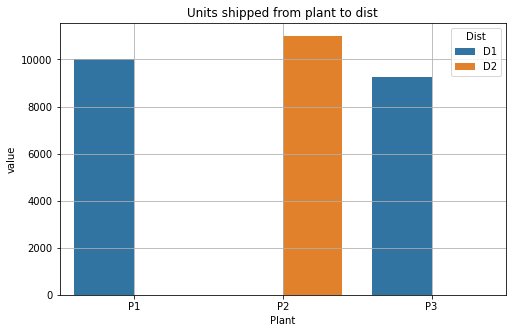

In [59]:
melted_dist = md.df_plant
melted_dist = pd.melt(md.df_plant)
melted_dist['Plant'] = ["P1", "P2", "P3"]*2
plt.figure(figsize=(8,5))
sns.barplot(x = 'Plant', y = 'value', hue = 'variable', data = melted_dist)
plt.grid()
plt.legend(title = "Dist")
plt.title("Units shipped from plant to dist")
plt.show()

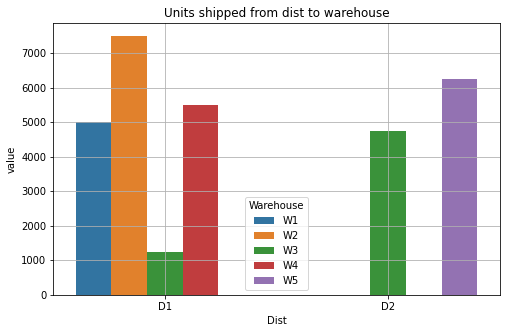

In [60]:
melted_dist = md.df_dist
melted_dist = pd.melt(md.df_dist)
melted_dist['Dist'] = md.DV1*5
plt.figure(figsize=(8,5))
sns.barplot(x = 'Dist', y = 'value', hue = 'variable', data = melted_dist)
plt.grid()
plt.legend(title = "Warehouse")
plt.title("Units shipped from dist to warehouse")
plt.show()

### Problem 5 - total cost as fx of edge cost

> Visualize how overall total cost changes as a function of cost at a single *edge* in the network. Test the P3 -> D1 edge on a sequence of costs from 0.5 to 0.7 in one cent increments, re-running the model for each.

In [61]:
p3_d1_costs = [(i + 50)/100 for i in list(range(0, 21))]
obj_vals = []
for cost in p3_d1_costs:
    md.cost1.loc["P3", "D1"] = cost
    run_model(md)
    obj_vals.append(md.obj_val)
result = zip(p3_d1_costs, obj_vals)
df_cost_change = pd.DataFrame(zip(p3_d1_costs, obj_vals), columns=["P3-D1", "Cost"])
df_cost_change

,P3-D1,Cost
0,0.50,29725.0
1,0.51,29830.0
2,0.52,29935.0
3,0.53,30040.0
4,0.54,30145.0
5,0.55,30250.0
6,0.56,30342.5
7,0.57,30435.0
8,0.58,30527.5
9,0.59,30620.0


#### 5a

> Plot overall shipping costs as a function of the change of this value.

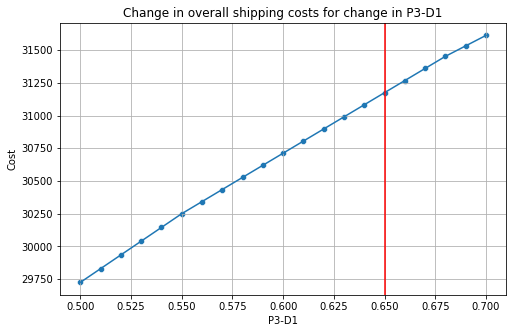

In [62]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = 'P3-D1', y = 'Cost', data = df_cost_change)
sns.lineplot(x = 'P3-D1', y = 'Cost', data = df_cost_change)
plt.grid()
plt.axvline(x = .65, color = "red")
plt.title("Change in overall shipping costs for change in P3-D1")
plt.show()

#### 5b

> Make two additional plots: (1.) Units shipped between P3 and the two distribution centers, and (2.) Units shipped between each distribution center and the 5 warehouses.

In [63]:
DV_list_plant = []
DV_list_dist = []
for val in p3_d1_costs:
    DV_curr_list_plant = []
    DV_curr_list_dist = []
    md.cost1.loc["P3", "D1"] = val
    run_model(md)
    for c in model.P3:
        DV_curr_list_plant.append(model.P3[c].value)
    for DV in [model.D1, model.D2]:
        for c in DV:
            DV_curr_list_dist.append(DV[c].value)
    DV_list_plant.append(DV_curr_list_plant)
    DV_list_dist.append(DV_curr_list_dist)

DV_df_plant = pd.DataFrame(DV_list_plant, columns=["P3-D1", "P3-D2"])
DV_df_dist = pd.DataFrame(DV_list_dist, columns= [f"{d}-{w}" for d in md.DV1 for w in md.DV2])
DV_df_plant["Costs"] = p3_d1_costs
DV_df_dist["Costs"] = p3_d1_costs
DV_df_plant

,P3-D1,P3-D2,Costs
0,10500.0,0.0,0.50
1,10500.0,0.0,0.51
2,10500.0,0.0,0.52
3,10500.0,0.0,0.53
4,10500.0,0.0,0.54
5,10500.0,0.0,0.55
6,9250.0,0.0,0.56
7,9250.0,0.0,0.57
8,9250.0,0.0,0.58
9,9250.0,0.0,0.59


In [64]:
DV_df_dist

,D1-W1,D1-W2,D1-W3,D1-W4,D1-W5,D2-W1,D2-W2,D2-W3,D2-W4,D2-W5,Costs
0,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.50
1,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.51
2,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.52
3,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.53
4,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.54
5,5000.0,7500.0,2500.0,5500.0,0.0,0.0,0.0,3500.0,0.0,6250.0,0.55
6,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.56
7,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.57
8,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.58
9,5000.0,7500.0,1250.0,5500.0,0.0,0.0,0.0,4750.0,0.0,6250.0,0.59


In [65]:
melted_plant = pd.melt(DV_df_plant, "Costs", value_name="Value")
melted_dist = pd.melt(DV_df_dist, "Costs", value_name="Value")
melted_plant

,Costs,variable,Value
0,0.50,P3-D1,10500.0
1,0.51,P3-D1,10500.0
2,0.52,P3-D1,10500.0
3,0.53,P3-D1,10500.0
4,0.54,P3-D1,10500.0
5,0.55,P3-D1,10500.0
6,0.56,P3-D1,9250.0
7,0.57,P3-D1,9250.0
8,0.58,P3-D1,9250.0
9,0.59,P3-D1,9250.0


In [66]:
melted_dist

,Costs,variable,Value
0,0.50,D1-W1,5000.0
1,0.51,D1-W1,5000.0
2,0.52,D1-W1,5000.0
3,0.53,D1-W1,5000.0
4,0.54,D1-W1,5000.0
...,...,...,...
205,0.66,D2-W5,6250.0
206,0.67,D2-W5,6250.0
207,0.68,D2-W5,6250.0
208,0.69,D2-W5,6250.0


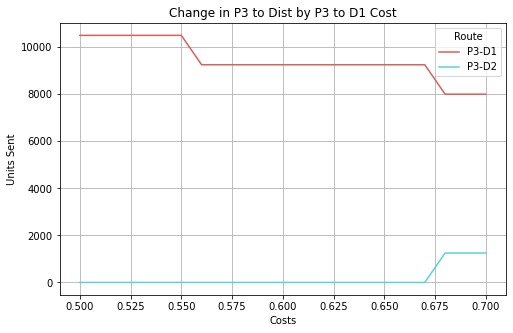

In [67]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Costs', y = 'Value', hue = 'variable', palette = sns.color_palette("hls", 2),
             data = melted_plant)
plt.grid()
plt.title('Change in P3 to Dist by P3 to D1 Cost')
plt.ylabel('Units Sent')
plt.legend(title = "Route")
plt.show()

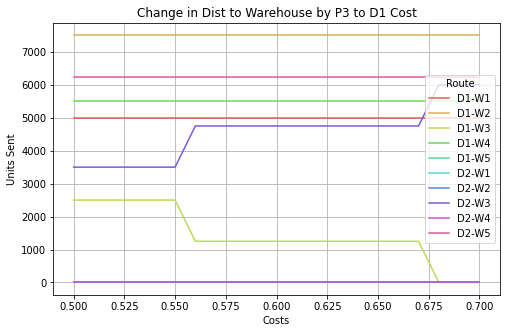

In [68]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Costs', y = 'Value', hue = 'variable', palette = sns.color_palette("hls", 10),
             data = melted_dist)
plt.grid()
plt.title('Change in Dist to Warehouse by P3 to D1 Cost')
plt.ylabel('Units Sent')
plt.legend(title = "Route")
plt.show()

#### Problem 6 - total cost as fx of demand

> Visualize how overall total cost changes as a function of demand (minimum units required) at a warehouse node. Test the W3 demand constraint on a sequence from 4700 to 7300 units, incrementing by 100, and re-run the model for each. Plot the change of total cost over the increase in W3 demand.

In [69]:
demand_w3 = [i*100 + 4700 for i in list(range(0, 27))]
obj_vals = []
for cost in demand_w3:
    md.demand.loc["W3", "Requirement"] = cost
    run_model(md)
    obj_vals.append(md.obj_val)
result = zip(demand_w3, obj_vals)
df_cost_change = pd.DataFrame(zip(demand_w3, obj_vals), columns=["W3-Demand", "Obj"])
df_cost_change

,W3-Demand,Obj
0,4700,30342.5
1,4800,30436.5
2,4900,30534.5
3,5000,30632.5
4,5100,30730.5
5,5200,30828.5
6,5300,30926.5
7,5400,31024.5
8,5500,31122.5
9,5600,31220.5


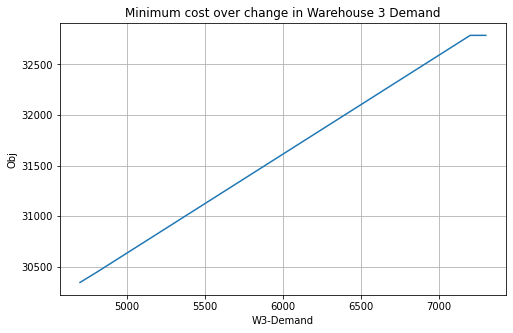

In [70]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'W3-Demand', y = 'Obj', data = df_cost_change)
plt.grid()
plt.title("Minimum cost over change in Warehouse 3 Demand")
plt.show()